Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'G:/github/lesson9/data/sample_data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [29]:
batch_size = 128
hiden_layer_node_num = 1024
beta = 0.01

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hiden_layer_node_num]))
  biases1 = tf.Variable(tf.zeros([hiden_layer_node_num]))
    
  weights2 = tf.Variable(
    tf.truncated_normal([hiden_layer_node_num, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
    
  # Training computation.
  a1 = tf.matmul(tf_train_dataset,weights1)+ biases1
  z1 = tf.nn.relu(a1)
  logits = tf.matmul(z1,weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  regularizers = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)
  loss = tf.reduce_mean(loss + beta * regularizers)

  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), weights2) + biases2)
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), weights2) + biases2)

In [30]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(session=session), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3448.736084
Minibatch accuracy: 7.0%
Validation accuracy: 29.2%
Minibatch loss at step 500: 21.294758
Minibatch accuracy: 86.7%
Validation accuracy: 83.8%
Minibatch loss at step 1000: 0.857664
Minibatch accuracy: 82.8%
Validation accuracy: 83.1%
Minibatch loss at step 1500: 0.738320
Minibatch accuracy: 82.8%
Validation accuracy: 83.2%
Minibatch loss at step 2000: 0.670285
Minibatch accuracy: 82.0%
Validation accuracy: 83.0%
Minibatch loss at step 2500: 0.936883
Minibatch accuracy: 75.8%
Validation accuracy: 83.3%
Minibatch loss at step 3000: 0.551285
Minibatch accuracy: 87.5%
Validation accuracy: 83.6%
Test accuracy: 90.7%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [12]:
batch_size = 128
hiden_layer_node_num = 1024
beta = 0.01

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hiden_layer_node_num]))
  biases1 = tf.Variable(tf.zeros([hiden_layer_node_num]))
    
  weights2 = tf.Variable(
    tf.truncated_normal([hiden_layer_node_num, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
    
  # Training computation.
  a1 = tf.matmul(tf_train_dataset,weights1)+ biases1
  z1 = tf.nn.relu(a1)
  logits = tf.matmul(z1,weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  regularizers = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)
  loss = tf.reduce_mean(loss + beta * regularizers)

  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), weights2) + biases2)
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), weights2) + biases2)

In [14]:
num_steps = 3001
train_dataset2 = train_dataset[:500, :]
train_labels2 = train_labels[:500, :]
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
   
    # Generate a minibatch.
    offset = (step * batch_size) % (train_labels2.shape[0] - batch_size)
    batch_data = train_dataset2[offset:(offset + batch_size), :]
    batch_labels = train_labels2[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(session=session), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3521.516357
Minibatch accuracy: 7.8%
Validation accuracy: 30.4%
Minibatch loss at step 500: 21.044577
Minibatch accuracy: 100.0%
Validation accuracy: 77.3%
Minibatch loss at step 1000: 0.465469
Minibatch accuracy: 100.0%
Validation accuracy: 78.1%
Minibatch loss at step 1500: 0.291680
Minibatch accuracy: 100.0%
Validation accuracy: 78.2%
Minibatch loss at step 2000: 0.272814
Minibatch accuracy: 100.0%
Validation accuracy: 78.0%
Minibatch loss at step 2500: 0.275493
Minibatch accuracy: 100.0%
Validation accuracy: 77.9%
Minibatch loss at step 3000: 0.266883
Minibatch accuracy: 100.0%
Validation accuracy: 77.9%
Test accuracy: 85.7%


In [23]:
num_steps = 3001
train_dataset2 = train_dataset[:228, :]
train_labels2 = train_labels[:228, :]
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    # Generate a minibatch.
    offset = (step * batch_size) % (train_labels2.shape[0] - batch_size)
    
    batch_data = train_dataset2[offset:(offset + batch_size), :]
    batch_labels = train_labels2[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(session=session), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3404.227295
Minibatch accuracy: 11.7%
Validation accuracy: 30.0%
Minibatch loss at step 500: 20.993330
Minibatch accuracy: 100.0%
Validation accuracy: 73.4%
Minibatch loss at step 1000: 0.398378
Minibatch accuracy: 100.0%
Validation accuracy: 75.0%
Minibatch loss at step 1500: 0.242608
Minibatch accuracy: 100.0%
Validation accuracy: 75.0%
Minibatch loss at step 2000: 0.233040
Minibatch accuracy: 100.0%
Validation accuracy: 74.8%
Minibatch loss at step 2500: 0.228234
Minibatch accuracy: 100.0%
Validation accuracy: 74.7%
Minibatch loss at step 3000: 0.224997
Minibatch accuracy: 100.0%
Validation accuracy: 74.8%
Test accuracy: 81.9%


In [ ]:
#所以问题2的结论是我们采用的数据量越小，测试准确率和 验证准确率越低，但是预测的准确率越高，迭代500次之后，预测的准确率达到了100%

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [31]:
batch_size = 128
hiden_layer_node_num = 1024
beta = 0.01

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hiden_layer_node_num]))
  biases1 = tf.Variable(tf.zeros([hiden_layer_node_num]))
    
  weights2 = tf.Variable(
    tf.truncated_normal([hiden_layer_node_num, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
    
  # Training computation.
  a1 = tf.matmul(tf_train_dataset,weights1)+ biases1
  relu_hide_layer = tf.nn.relu(a1)
  #*****************相对于以上的代码修改的地方
  drop_prob = tf.placeholder(tf.float32)
  relu_layer_dropout = tf.nn.dropout(relu_hide_layer,rate = drop_prob)#删除一部分神经元
  logits = tf.matmul(relu_layer_dropout, weights2) + biases2
  #logits = tf.matmul(relu_layer_dropout,weights2) + biases2
  #*****************
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  regularizers = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)
  loss = tf.reduce_mean(loss + beta * regularizers)

  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), weights2) + biases2)
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), weights2) + biases2)

In [37]:
num_steps = 3001
drop_prob_value = 0.5 


with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    # Generate a minibatch.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,drop_prob : drop_prob_value}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(session=session), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3627.716797
Minibatch accuracy: 5.5%
Validation accuracy: 32.3%
Minibatch loss at step 500: 21.443213
Minibatch accuracy: 82.8%
Validation accuracy: 83.5%
Minibatch loss at step 1000: 0.908184
Minibatch accuracy: 83.6%
Validation accuracy: 82.8%
Minibatch loss at step 1500: 0.829966
Minibatch accuracy: 82.0%
Validation accuracy: 82.8%
Minibatch loss at step 2000: 0.716502
Minibatch accuracy: 82.0%
Validation accuracy: 82.3%
Minibatch loss at step 2500: 0.982966
Minibatch accuracy: 73.4%
Validation accuracy: 83.2%
Minibatch loss at step 3000: 0.656911
Minibatch accuracy: 85.9%
Validation accuracy: 83.3%
Test accuracy: 90.5%


In [ ]:
#drop_prob= 0.2 剔除的概率设为0.2 结果和0.5的测试准确率一样

In [39]:
num_steps = 3001
drop_prob_value = 0.7

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    # Generate a minibatch.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,drop_prob : drop_prob_value}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(session=session), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3766.765381
Minibatch accuracy: 12.5%
Validation accuracy: 27.8%
Minibatch loss at step 500: 21.992350
Minibatch accuracy: 76.6%
Validation accuracy: 82.4%
Minibatch loss at step 1000: 1.079805
Minibatch accuracy: 82.0%
Validation accuracy: 82.0%
Minibatch loss at step 1500: 0.975252
Minibatch accuracy: 78.1%
Validation accuracy: 82.6%
Minibatch loss at step 2000: 0.879081
Minibatch accuracy: 79.7%
Validation accuracy: 81.5%
Minibatch loss at step 2500: 1.092757
Minibatch accuracy: 72.7%
Validation accuracy: 82.6%
Minibatch loss at step 3000: 0.785902
Minibatch accuracy: 83.6%
Validation accuracy: 82.7%
Test accuracy: 90.2%


In [ ]:
#剔除的神经元越多，则准确率就会有所下降

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [46]:
import  math

batch_size = 128
beta = 0.001

hidden_nodes_1 = 1024
hidden_nodes_2 = int(hidden_nodes_1 * 0.5)
hidden_nodes_3 = int(hidden_nodes_1 * np.power(0.5, 2))
hidden_nodes_4 = int(hidden_nodes_1 * np.power(0.5, 3))
hidden_nodes_5 = int(hidden_nodes_1 * np.power(0.5, 4))

gragh = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes_1], stddev=math.sqrt(2.0/(image_size*image_size))))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes_1]))
    
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes_1, hidden_nodes_2], stddev=math.sqrt(2.0/hidden_nodes_1)))
    biases_2 = tf.Variable(tf.zeros([hidden_nodes_2]))
    
    weights_3 = tf.Variable(tf.truncated_normal([hidden_nodes_2, hidden_nodes_3], stddev=math.sqrt(2.0/hidden_nodes_2)))
    biases_3 = tf.Variable(tf.zeros([hidden_nodes_3]))
    
    weights_4 = tf.Variable(tf.truncated_normal([hidden_nodes_3, hidden_nodes_4], stddev=math.sqrt(2.0/hidden_nodes_3)))
    biases_4 = tf.Variable(tf.zeros([hidden_nodes_4]))
    
    weights_5 = tf.Variable(tf.truncated_normal([hidden_nodes_4, hidden_nodes_5], stddev=math.sqrt(2.0/hidden_nodes_4)))
    biases_5 = tf.Variable(tf.zeros([hidden_nodes_5]))
    
    weights_6 = tf.Variable(tf.truncated_normal([hidden_nodes_5, num_labels], stddev=math.sqrt(2.0/hidden_nodes_5)))
    biases_6 = tf.Variable(tf.zeros([num_labels]))
    
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    hidden_layer_1 = tf.nn.relu(logits_1)
    drop_prob = tf.placeholder('float')
    hidden_layer_1_dropout = tf.nn.dropout(hidden_layer_1, rate = drop_prob)
    
    logits_2 = tf.matmul(hidden_layer_1_dropout, weights_2) + biases_2
    hidden_layer_2 = tf.nn.relu(logits_2)
    hidden_layer_2_dropout = tf.nn.dropout(hidden_layer_2, rate = drop_prob)
    
    # Hidden RELU layer 3
    logits_3 = tf.matmul(hidden_layer_2_dropout, weights_3) + biases_3
    hidden_layer_3 = tf.nn.relu(logits_3)
    # Dropout on hidden layer: RELU layer
    hidden_layer_3_dropout = tf.nn.dropout(hidden_layer_3, rate = drop_prob)
    
    # Hidden RELU layer 4
    logits_4 = tf.matmul(hidden_layer_3_dropout, weights_4) + biases_4
    hidden_layer_4 = tf.nn.relu(logits_4)
    # Dropout on hidden layer: RELU layer

    hidden_layer_4_dropout = tf.nn.dropout(hidden_layer_4, rate = drop_prob)
    
    # Hidden RELU layer 5
    logits_5 = tf.matmul(hidden_layer_4_dropout, weights_5) + biases_5
    hidden_layer_5 = tf.nn.relu(logits_5)
    # Dropout on hidden layer: RELU layer
    hidden_layer_5_dropout = tf.nn.dropout(hidden_layer_5, rate = drop_prob)
    
    # Output layer
    logits_6 = tf.matmul(hidden_layer_5_dropout, weights_6) + biases_6 
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_6, labels=tf_train_labels))
    # Loss function with L2 Regularization with decaying learning rate beta=0.5
    regularizers = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + \
                   tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(weights_4) + \
                   tf.nn.l2_loss(weights_5) + tf.nn.l2_loss(weights_6)
    loss = tf.reduce_mean(loss + beta * regularizers)
    
    '''Optimizer'''
    # Decaying learning rate
    global_step = tf.Variable(0)  # count the number of steps taken.
    start_learning_rate = 0.5
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 1000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_6)
    
    # Predictions for validation 
    valid_logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    valid_relu_1 = tf.nn.relu(valid_logits_1)
    
    valid_logits_2 = tf.matmul(valid_relu_1, weights_2) + biases_2
    valid_relu_2 = tf.nn.relu(valid_logits_2)
    
    valid_logits_3 = tf.matmul(valid_relu_2, weights_3) + biases_3
    valid_relu_3 = tf.nn.relu(valid_logits_3)
    
    valid_logits_4 = tf.matmul(valid_relu_3, weights_4) + biases_4
    valid_relu_4 = tf.nn.relu(valid_logits_4)
    
    valid_logits_5 = tf.matmul(valid_relu_4, weights_5) + biases_5
    valid_relu_5 = tf.nn.relu(valid_logits_5)
    
    valid_logits_6 = tf.matmul(valid_relu_5, weights_6) + biases_6
    
    valid_prediction = tf.nn.softmax(valid_logits_6)
    
    # Predictions for test
    test_logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    test_relu_1 = tf.nn.relu(test_logits_1)
    
    test_logits_2 = tf.matmul(test_relu_1, weights_2) + biases_2
    test_relu_2 = tf.nn.relu(test_logits_2)
    
    test_logits_3 = tf.matmul(test_relu_2, weights_3) + biases_3
    test_relu_3 = tf.nn.relu(test_logits_3)
    
    test_logits_4 = tf.matmul(test_relu_3, weights_4) + biases_4
    test_relu_4 = tf.nn.relu(test_logits_4)
    
    test_logits_5 = tf.matmul(test_relu_4, weights_5) + biases_5
    test_relu_5 = tf.nn.relu(test_logits_5)
    
    test_logits_6 = tf.matmul(test_relu_5, weights_6) + biases_6
    
    test_prediction = tf.nn.softmax(test_logits_6)

In [47]:
num_steps = 15001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, drop_prob:0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 5.004217
Minibatch accuracy: 10.2%
Validation accuracy: 7.3%
Minibatch loss at step 500: 1.880380
Minibatch accuracy: 79.7%
Validation accuracy: 81.5%
Minibatch loss at step 1000: 1.510096
Minibatch accuracy: 80.5%
Validation accuracy: 83.6%
Minibatch loss at step 1500: 1.173761
Minibatch accuracy: 82.8%
Validation accuracy: 84.1%
Minibatch loss at step 2000: 0.994968
Minibatch accuracy: 84.4%
Validation accuracy: 85.0%
Minibatch loss at step 2500: 1.102418
Minibatch accuracy: 77.3%
Validation accuracy: 85.2%
Minibatch loss at step 3000: 0.762941
Minibatch accuracy: 86.7%
Validation accuracy: 86.1%
Minibatch loss at step 3500: 0.770632
Minibatch accuracy: 85.9%
Validation accuracy: 85.6%
Minibatch loss at step 4000: 0.814666
Minibatch accuracy: 83.6%
Validation accuracy: 85.8%
Minibatch loss at step 4500: 0.748674
Minibatch accuracy: 84.4%
Validation accuracy: 86.2%
Minibatch loss at step 5000: 0.735886
Minibatch accuracy: 83.6%
Validation accuracy

In [49]:
num_steps = 15001
losses = []
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, drop_prob:0.1}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      losses.append(l)
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.898955
Minibatch accuracy: 8.6%
Validation accuracy: 15.9%
Minibatch loss at step 500: 1.499580
Minibatch accuracy: 84.4%
Validation accuracy: 84.7%
Minibatch loss at step 1000: 1.097355
Minibatch accuracy: 85.2%
Validation accuracy: 85.5%
Minibatch loss at step 1500: 0.880821
Minibatch accuracy: 85.9%
Validation accuracy: 86.6%
Minibatch loss at step 2000: 0.750510
Minibatch accuracy: 88.3%
Validation accuracy: 87.2%
Minibatch loss at step 2500: 0.856742
Minibatch accuracy: 80.5%
Validation accuracy: 88.0%
Minibatch loss at step 3000: 0.480169
Minibatch accuracy: 94.5%
Validation accuracy: 88.2%
Minibatch loss at step 3500: 0.532530
Minibatch accuracy: 90.6%
Validation accuracy: 88.4%
Minibatch loss at step 4000: 0.528216
Minibatch accuracy: 89.8%
Validation accuracy: 87.9%
Minibatch loss at step 4500: 0.492492
Minibatch accuracy: 89.8%
Validation accuracy: 88.1%
Minibatch loss at step 5000: 0.563306
Minibatch accuracy: 88.3%
Validation accuracy

In [51]:
 %matplotlib inline


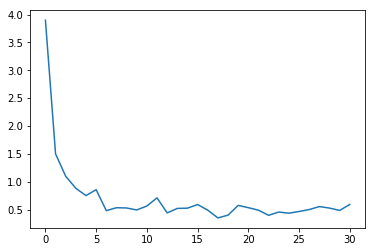

In [52]:
import matplotlib.pyplot as plt
plt.plot(losses)